In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import os
import shutil
import random

# Define the source and destination directories
source_dir = '/content/drive/MyDrive/deepfakeimg/dataset2/test'  # Replace with your source directory
test_dir = '/content/drive/MyDrive/deepfakeimg/dataset2' # Replace with your destination directory

# Create the destination directory if it doesn't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Define the classes
classes = ['real', 'fake']

# Iterate through the classes
for class_name in classes:
    source_class_dir = os.path.join(source_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    # Create the class directory in the test set if it doesn't exist
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

    # Get a list of all files in the source class directory
    files = os.listdir(source_class_dir)

    # Calculate the number of files to move (10%)
    num_files_to_move = int(len(files) * 0.1)

    # Randomly select files to move
    files_to_move = random.sample(files, num_files_to_move)

    # Move the selected files to the test directory
    for file_name in files_to_move:
      source_file = os.path.join(source_class_dir, file_name)
      destination_file = os.path.join(test_class_dir, file_name)
      shutil.move(source_file, destination_file)

In [ ]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Fix for truncated image error

# Define the path to the dataset
data_dir = '/content/drive/MyDrive/deepfakeimg/dataset2/test'  # Use your original dataset path
test_dir = '/content/drive/MyDrive/deepfakeimg/dataset2/real_test' # Replace with your destination directory
# Image Data Generators with Data Augmentation for training and rescaling for validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0,
    validation_split=0.1  # Use 10% for validation, 90% for training
)

# Training Data Generator (90% of the data)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training'  # Specifies this is the training subset
)

# Validation Data Generator (10% of the data)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='validation'  # Specifies this is the validation subset
)

# Test Data Generator (same directory, but no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=True  # Set shuffle to False for evaluation
)


Found 9720 images belonging to 2 classes.
Found 1080 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [ ]:


from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input

def create_deepfake_detection_model(input_shape=(299, 299, 3)):
    # Create an input layer with explicit shape
    inputs = Input(shape=input_shape)

    # Load Xception model
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )

    # Unfreeze the last 10 layers
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Freeze remaining layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Get the output from base model
    x = base_model.output

    # Add texture extraction layers with explicit shapes
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='texture_conv1_1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='texture_conv1_2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='texture_pool1')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='texture_conv2_1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='texture_conv2_2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='texture_pool2')(x)

    # Global pooling
    x = GlobalAveragePooling2D(name='global_pooling')(x)

    # Dense layers
    x = Dense(256, activation='relu', name='dense_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    outputs = Dense(1, activation='sigmoid', name='output')(x)

    # Create model using functional API
    model = Model(inputs=inputs, outputs=outputs, name='deepfake_detector')

    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
model = create_deepfake_detection_model()
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "deepfake_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,532,905 (82.14 MB)

 Trainable params: 6,167,745 (23.53 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

In [ ]:


from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with verbosity
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=13,
    callbacks=[early_stopping],  # Adding early stopping callback
    verbose=1  # Displays progress bar
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/13
166/338 ━━━━━━━━━━━━━━━━━━━━ 1:14:10 26s/step - accuracy: 0.8168 - loss: 0.4355

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


338/338 ━━━━━━━━━━━━━━━━━━━━ 9861s 29s/step - accuracy: 0.8295 - loss: 0.4127 - val_accuracy: 0.8342 - val_loss: 0.3902
Epoch 2/13
338/338 ━━━━━━━━━━━━━━━━━━━━ 999s 3s/step - accuracy: 0.8830 - loss: 0.2945 - val_accuracy: 0.8667 - val_loss: 0.3132
Epoch 3/13
338/338 ━━━━━━━━━━━━━━━━━━━━ 1006s 3s/step - accuracy: 0.9105 - loss: 0.2353 - val_accuracy: 0.7708 - val_loss: 0.6721
Epoch 4/13
338/338 ━━━━━━━━━━━━━━━━━━━━ 1010s 3s/step - accuracy: 0.9247 - loss: 0.2009 - val_accuracy: 0.8775 - val_loss: 0.3482
Epoch 5/13
338/338 ━━━━━━━━━━━━━━━━━━━━ 1020s 3s/step - accuracy: 0.9308 - loss: 0.1764 - val_accuracy: 0.8725 - val_loss: 0.3313
Epoch 6/13
338/338 ━━━━━━━━━━━━━━━━━━━━ 1010s 3s/step - accuracy: 0.9448 - loss: 0.1507 - val_accuracy: 0.8642 - val_loss: 0.4001
Epoch 7/13
338/338 ━━━━━━━━━━━━━━━━━━━━ 1004s 3s/step - accuracy: 0.9458 - loss: 0.1399 - val_accuracy: 0.7767 - val_loss: 0.8627
375/375 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.9228 - loss: 0.2006
Test Accuracy: 0.8924


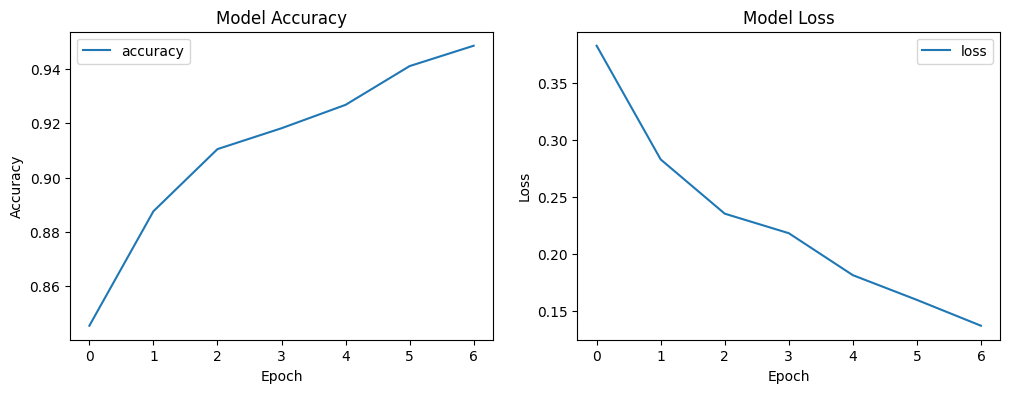

In [ ]:


# Plot the training accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/deepfakeimg/deepfake_xception_model_2.h5')


In [ ]:
# prompt: give a code to load a deeplearning model

import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/deepfakeimg/deepfake_xception_model_2.h5')
# you can now use the model to predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


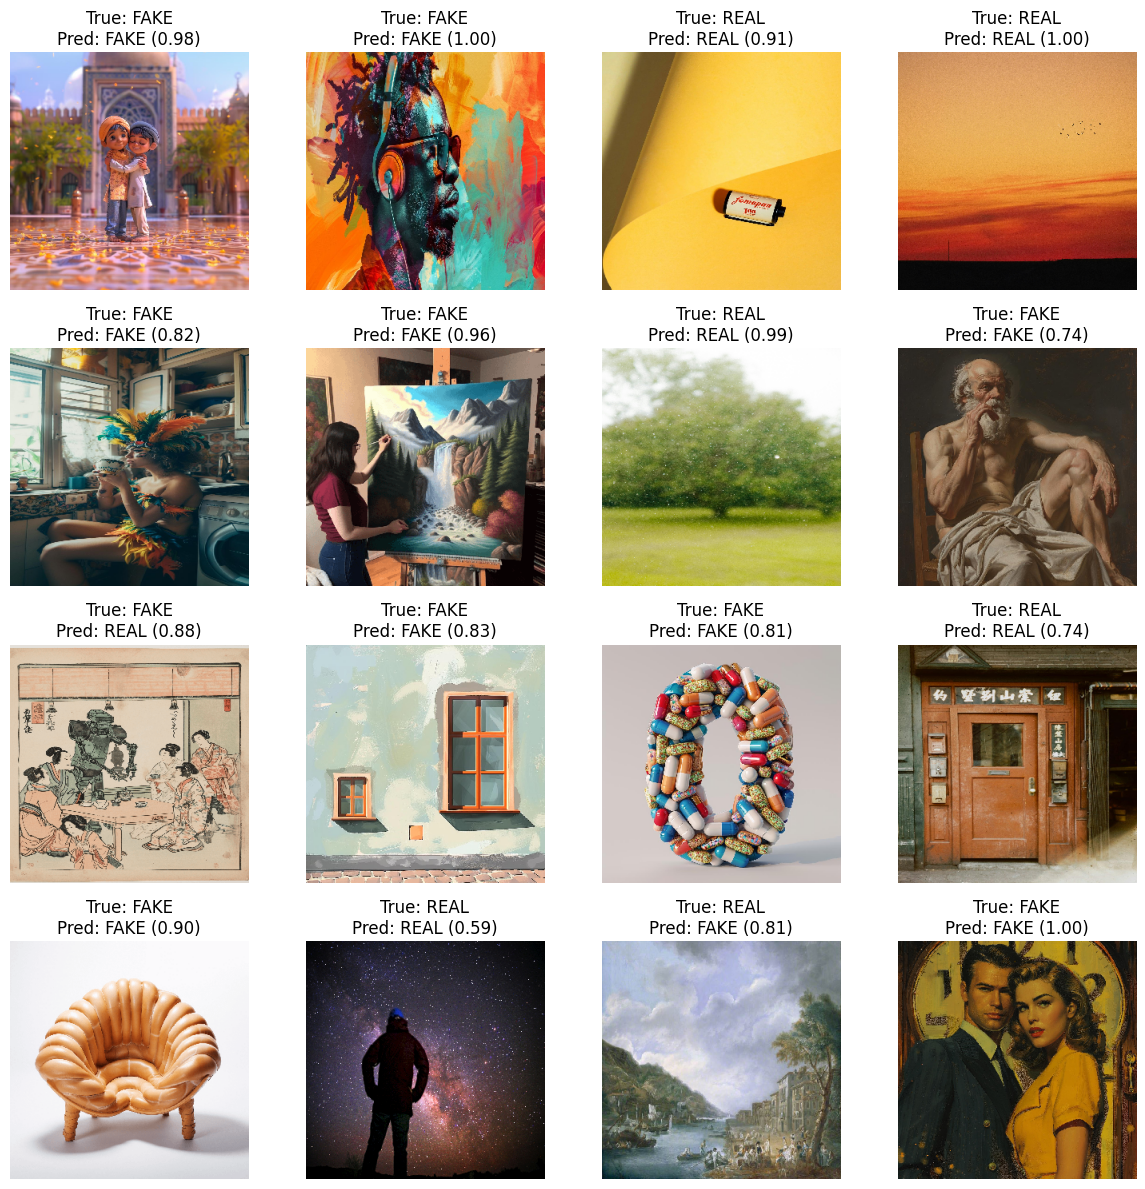

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Get a batch of images from the test generator
# Assuming `test_generator` has already been defined
# Set batch size to fetch enough samples for random selection
test_generator.reset()
batch = next(test_generator)

# Extract images and labels from the batch
test_images, test_labels = batch

# Get predictions for the batch
predictions = model.predict(test_images)

# Select 9 random indices from the batch
random_indices = random.sample(range(len(test_images)), 16)

# Plotting random 9 images with predictions
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices):
    img = test_images[idx]
    true_label = "REAL" if test_labels[idx] == 1 else "FAKE"
    pred_prob = predictions[idx][0]

    # Updated prediction logic based on your label mapping
    pred_label = "REAL" if pred_prob >= 0.5 else "FAKE"
    confidence = pred_prob if pred_label == "REAL" else 1 - pred_prob

    # Display the image with its predicted label
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()


Saving 52721eab-5953-4520-ae97-000fe625b878_360_640.jpeg to 52721eab-5953-4520-ae97-000fe625b878_360_640.jpeg


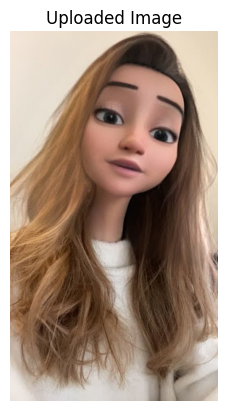

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Prediction: FAKE (Confidence: 1.00)


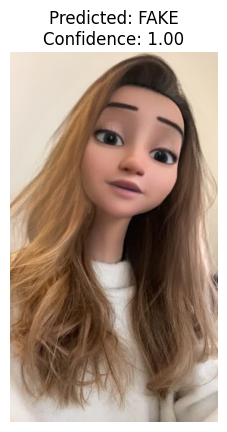

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
from PIL import Image as PILImage
import io

# Function to preprocess the uploaded image
def preprocess_image(image_path, target_size=(299, 299)):
    img = load_img(image_path, target_size=target_size)   # Load image with target size
    img_array = img_to_array(img) / 255.0                 # Convert to array and normalize
    return np.expand_dims(img_array, axis=0)              # Add batch dimension

# Upload an image
uploaded = files.upload()

# Loop through uploaded files
for file_name in uploaded.keys():
    # Check if the uploaded image is in `.webp` format
    if file_name.lower().endswith('.webp'):
        # Convert .webp to .png using PIL
        with PILImage.open(file_name) as img:
            img = img.convert('RGB')  # Convert to RGB
            png_filename = file_name.replace('.webp', '.png')
            img.save(png_filename)
            file_name = png_filename

    # Display the uploaded image
    img_display = PILImage.open(file_name)
    plt.imshow(img_display)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img = preprocess_image(file_name)

    # Make prediction
    prediction = model.predict(img)[0][0]

    # Determine the class label
    label = "REAL" if prediction >= 0.5 else "FAKE"
    confidence = prediction if label == "REAL" else 1 - prediction

    # Display result
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")

    # Plot the image using Matplotlib
    plt.imshow(load_img(file_name))
    plt.title(f"Predicted: {label}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()


In [ ]:
print(test_generator.class_indices)


{'fake': 0, 'real': 1}
